In [1]:
import pandas as pd
import numpy as np
from src.preprocessing import load_and_process_data, create_user_sequences, train_test_split_by_user
from src.hmm import HiddenMarkovModel,EdgeEmittingHiddenMarkovModel,ThreeGramHiddenMarkovModel
from src.baselines import TimeOfDayBaseline, FrequencyBaseline
from src.utils import LabelEncoder, calculate_accuracy
from src.baselines import TimeOfDayBaseline, FrequencyBaseline,RFBaseline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

**DATA**

In [2]:
data_path = "./data/mode_purpose_hmm.csv" # Adjust path if necessary
df = load_and_process_data(data_path)
user_sequences = create_user_sequences(df, obs_config="mode_only") # Choose between "mode_only", "mode_time_of_day", "mode_hour"
# Looks like mode_hour performs the best!

In [3]:
train_seqs, test_seqs = train_test_split_by_user(user_sequences, test_size=0.2)

In [4]:
# sample entry
print(train_seqs[0])

[('car', 'errand', Timestamp('2021-08-04 19:22:46+0000', tz='UTC')), ('walk', 'home', Timestamp('2021-08-04 21:03:32+0000', tz='UTC')), ('car', 'home', Timestamp('2021-08-04 21:33:50+0000', tz='UTC'))]


In [5]:
# encode data
mode_encoder = LabelEncoder()
purpose_encoder = LabelEncoder()

all_modes = set()
all_purposes = set()

for seq in train_seqs+test_seqs:
    for mode,purpose,_ in seq:
        all_modes.add(mode)
        all_purposes.add(purpose)


In [6]:
mode_encoder.fit(list(all_modes))
purpose_encoder.fit(list(all_purposes))

In [7]:
print(f"Modes: {mode_encoder.classes_}")
print(f"Purposes: {purpose_encoder.classes_}")

Modes: ['bike', 'bus', 'car', 'train', 'walk']
Purposes: ['eat', 'errand', 'home', 'leisure', 'work']


**BASELINE**

***JustHome***

In [8]:
home_true = []
home_pred = []

for seq in test_seqs:
    for _,gt_purpose, timestamp in seq:
        home_true.append(gt_purpose)
        pred = "home"
        home_pred.append(pred)

acc_tod = accuracy_score(home_true, home_pred)
print(f"Home Baseline Accuracy: {acc_tod:.4f}")

Home Baseline Accuracy: 0.3522


***Rule-based***

In [9]:
# rule-based, predict purpose given time of day

tod_baseline = TimeOfDayBaseline()

tod_true = []
tod_pred = []

for seq in test_seqs:
    for _,gt_purpose, timestamp in seq:
        tod_true.append(gt_purpose)
        pred = tod_baseline.predict(timestamp)
        tod_pred.append(pred)

acc_tod = accuracy_score(tod_true, tod_pred)
print(f"TimeOfDay Baseline Accuracy: {acc_tod:.4f}")



TimeOfDay Baseline Accuracy: 0.2092


***Frequency-based***

In [10]:
freq_baseline = FrequencyBaseline()

# get mode and purpose, w/o timestamps
train_seqs_stripped = [[(row[0], row[1]) for row in seq] for seq in train_seqs]

# training
freq_baseline.fit(train_seqs_stripped)

freq_true_flattened = []
freq_pred_flattened = []

# prediction
for seq in test_seqs:
    for row in seq:
        mode, true_purpose, _ = row  
        
        pred_purpose = freq_baseline.predict(mode)
        
        freq_true_flattened.append(true_purpose)
        freq_pred_flattened.append(pred_purpose)

acc_freq = accuracy_score(freq_true_flattened, freq_pred_flattened)
print(f"Frequency Baseline Accuracy: {acc_freq:.4f}")

Frequency Baseline Accuracy: 0.2722


***Random Forest***

In [11]:
def prepare_rf_data(sequences, m_encoder, p_encoder):
    """
    convert (mode,purpose,timestamp) to X= [mode,timestamp], y = [purpose]
    """
    X = []
    y = []
    for seq in sequences: # daily trips 
        for row in seq: # one trip with mode, purpose, time 
            mode, purpose, timestamp = row
            
            # feature 1 :mode of the trip 
            m_idx = m_encoder.transform([mode])[0]
            
            # feature 2: hour of day 
            hour = timestamp.hour
            
            X.append([m_idx, hour])
            
            # gt purpose 
            p_idx = p_encoder.transform([purpose])[0]
            y.append(p_idx)
            
    return np.array(X), np.array(y)

In [12]:
X_train, y_train = prepare_rf_data(train_seqs, mode_encoder, purpose_encoder)
X_test, y_test = prepare_rf_data(test_seqs, mode_encoder, purpose_encoder)

In [13]:
rf_baseline = RFBaseline(n_estimators=300,random_seed=42)
rf_baseline.fit(X_train,y_train)

In [14]:
y_pred = rf_baseline.predict(X_test)
y_test_label = purpose_encoder.inverse_transform(y_test)
y_pred_label = purpose_encoder.inverse_transform(y_pred)

In [15]:
acc_rf = accuracy_score(y_test_label, y_pred_label)
print(f"Random Forest Accuracy: {acc_rf:.4f}")

Random Forest Accuracy: 0.4617


***Standard 1-Gram HMM***

In [16]:
# HMM Model
hmm = HiddenMarkovModel(num_states=len(purpose_encoder), num_observations=len(mode_encoder))

# Train (MLE)
hmm.maximum_likelihood_initialize_parameters(train_seqs, purpose_encoder, mode_encoder)

# Predict (Viterbi)
true_purposes = []
pred_purposes = []

for i, seq in enumerate(test_seqs):
    # Extract modes and purposes
    modes = [row[0] for row in seq]
    purposes = [row[1] for row in seq]
    
    # Encode modes to integers
    obs_seq = mode_encoder.transform(modes)
    
    # Predict
    pred_indices = hmm.predict_viterbi(obs_seq)
    
    # Decode predictions
    pred_labels = purpose_encoder.inverse_transform(pred_indices)
    
    true_purposes.append(purposes)
    pred_purposes.append(pred_labels)
    # print(purposes)
    # print(pred_labels)
    # print("======")
    # if i == 10:
    #     break
    

# Accuracy
acc_hmm = calculate_accuracy(true_purposes, pred_purposes)
print(f"HMM Accuracy: {acc_hmm:.4f}")

HMM Accuracy: 0.3561


While this attempt performs better than the rule-based and frequency-based baselines, it is still not as good as the Random Forest model. Upon observation of some of the predictions/labels, it seems that the HMM model is biased towards state transitions that reach the "home" purpose. This may be fixed with a higher-order HMM model. If not, then we may need to clean the data or make the number of purposes more granular.

***3-gram HMM***

In [17]:
# 3-Gram HMM Model
hmm3 = ThreeGramHiddenMarkovModel(num_states=len(purpose_encoder), num_observations=len(mode_encoder))

# Train (MLE)
hmm3.maximum_likelihood_initialize_parameters(train_seqs, purpose_encoder, mode_encoder)

# Predict (Viterbi)
true_purposes_3 = []
pred_purposes_3 = []

for i, seq in enumerate(test_seqs):
    # Extract modes and purposes
    modes = [row[0] for row in seq]
    purposes = [row[1] for row in seq]
    
    # Encode modes to integers
    obs_seq = mode_encoder.transform(modes)
    
    # Predict
    pred_indices = hmm3.predict_viterbi(obs_seq)
    
    # Decode predictions
    pred_labels = purpose_encoder.inverse_transform(pred_indices)
    
    true_purposes_3.append(purposes)
    pred_purposes_3.append(pred_labels)

# Accuracy
acc_hmm3 = calculate_accuracy(true_purposes_3, pred_purposes_3)
print(f"3-Gram HMM Accuracy: {acc_hmm3:.4f}")

3-Gram HMM Accuracy: 0.3240


***Edge-emitting HMM***

In [18]:
# num of hidden states (purposes) and observations (modes)
K = len(purpose_encoder.classes_)
V = len(mode_encoder.classes_)

edge_hmm = EdgeEmittingHiddenMarkovModel(
    num_states=K,
    num_observations=V,
    smoothing=1.0,   # Laplace smoothing
)

edge_hmm.maximum_likelihood_initialize_parameters(
    train_sequences=train_seqs,
    purpose_encoder=purpose_encoder,
    mode_encoder=mode_encoder,
)


In [19]:
# --- Predict edge-HMM on test sequences ---
true_purposes_edge = []
pred_purposes_edge = []

for i, seq in enumerate(test_seqs):
    if len(seq) == 0:
        continue
        
    # extract modes and purposes
    modes = [row[0] for row in seq]
    purposes = [row[1] for row in seq]

    # encode modes
    obs_seq = mode_encoder.transform(modes)

    # predict
    pred_indices = edge_hmm.predict_viterbi(obs_seq)

    # decode indices into purpose labels
    pred_labels = purpose_encoder.inverse_transform(pred_indices)

    # append
    true_purposes_edge.append(purposes)
    pred_purposes_edge.append(pred_labels)

acc_edge_hmm = calculate_accuracy(true_purposes_edge, pred_purposes_edge)
print(f"Edge-Emitting HMM Accuracy: {acc_edge_hmm:.4f}")


Edge-Emitting HMM Accuracy: 0.3950


***EVALUATION***

In [20]:
def eval_baseline(y_true,y_pred,label_names,title="Confusion Matrix"):

    cm = confusion_matrix(y_true, y_pred, normalize="true")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    _, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
    plt.title(title)
    plt.show()
    

***Time of Day Eval***

[[0.35793358 0.         0.17560234 0.14108965 0.32537443]
 [0.21543896 0.         0.21872279 0.07090081 0.49493743]
 [0.29442542 0.         0.19624424 0.16515885 0.34417149]
 [0.24426714 0.         0.19900415 0.09459034 0.46213837]
 [0.12492377 0.         0.27022021 0.0235799  0.58127612]]


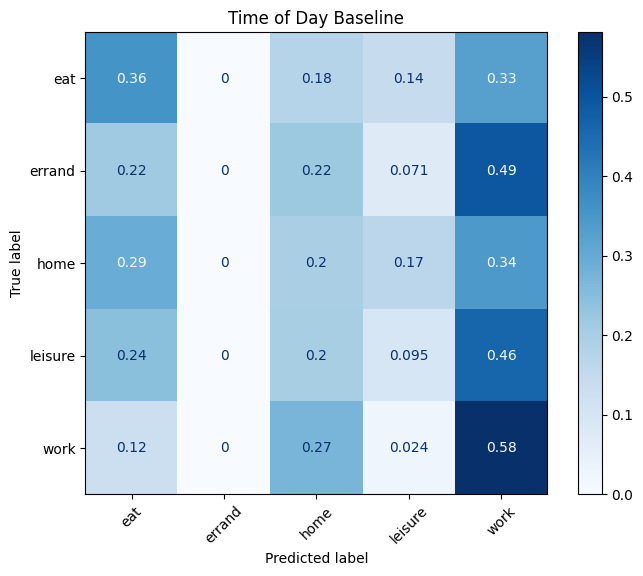

In [21]:
PURPOSE_NAMES = purpose_encoder.classes_
eval_baseline(
    y_true=tod_true,
    y_pred=tod_pred,
    label_names=PURPOSE_NAMES,
    title="Time of Day Baseline"
)


***Frequency-based Eval***

[[0.0217061  0.17169525 0.34078576 0.288257   0.17755589]
 [0.01965321 0.19864667 0.33388064 0.26780606 0.18001343]
 [0.01749144 0.15697413 0.35657258 0.27511515 0.1938467 ]
 [0.019362   0.16158495 0.34914588 0.2780569  0.19185026]
 [0.01596838 0.16490119 0.35261434 0.27143986 0.19507623]]


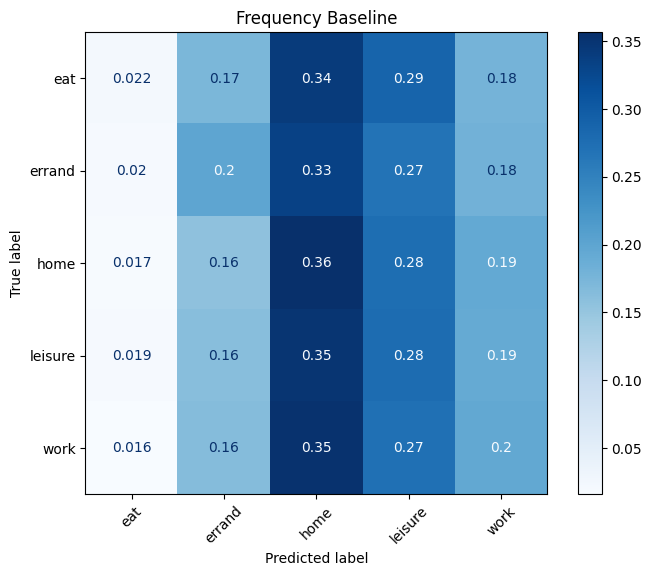

In [22]:
eval_baseline(
    y_true=freq_true_flattened,
    y_pred=freq_pred_flattened,
    label_names=PURPOSE_NAMES,
    title="Frequency Baseline"
)


***Random Forest Eval***

[[0.         0.04514869 0.48339483 0.44606034 0.02539614]
 [0.         0.13667687 0.40560241 0.36460432 0.0931164 ]
 [0.         0.02124719 0.67298925 0.27464273 0.03112082]
 [0.         0.03127015 0.46380311 0.45657423 0.04835251]
 [0.         0.04921513 0.22403162 0.31846414 0.4082891 ]]


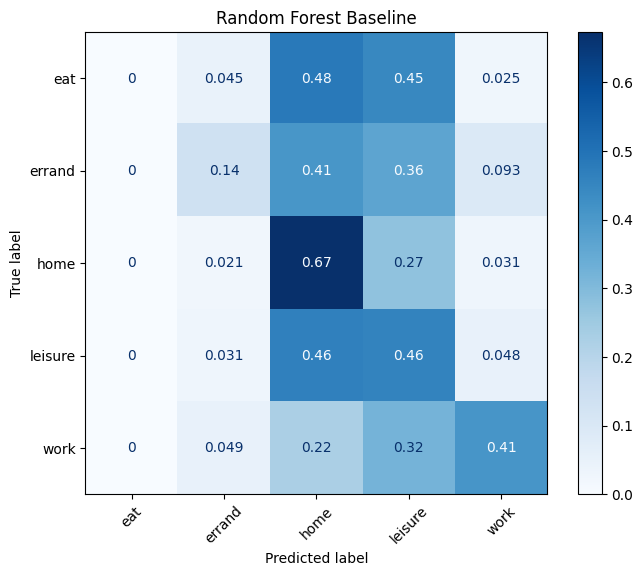

In [23]:
eval_baseline(
    y_true=y_test,
    y_pred=y_pred,
    label_names=PURPOSE_NAMES,
    title="Random Forest Baseline"
)


***HMM Eval***

[[0.         0.07358368 0.25743434 0.56327328 0.1057087 ]
 [0.         0.2070055  0.26225838 0.38497898 0.14575715]
 [0.         0.03663635 0.45020668 0.35235621 0.16080076]
 [0.         0.04272838 0.32912399 0.4625583  0.16558933]
 [0.         0.0964201  0.34857143 0.36684359 0.18816488]]


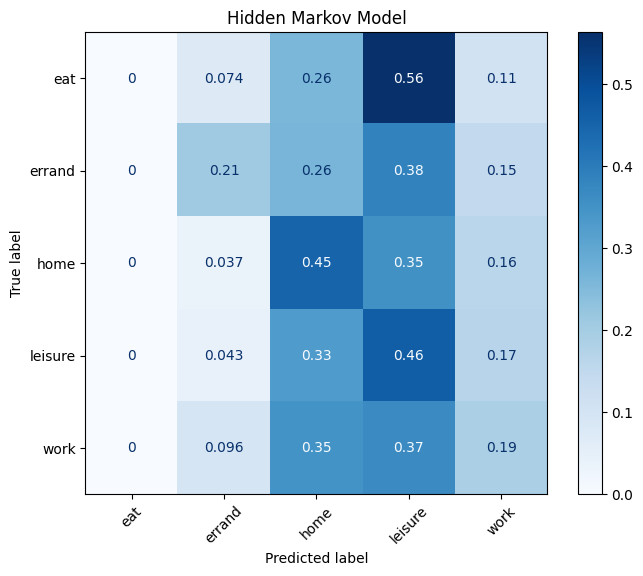

In [24]:
hmm_true = [label for seq in true_purposes for label in seq]
hmm_pred = [label for seq in pred_purposes for label in seq]

eval_baseline(
    y_true=hmm_true,
    y_pred=hmm_pred,
    label_names=PURPOSE_NAMES,
    title="Hidden Markov Model"
)


***3-gram HMM Eval***

[[0.03299327 0.0879097  0.07662253 0.58649881 0.21597569]
 [0.0381123  0.21747892 0.07463244 0.38351121 0.28626514]
 [0.06878469 0.04243534 0.21427897 0.35084445 0.32365655]
 [0.02872055 0.05039219 0.10025946 0.4677325  0.3528953 ]
 [0.02405421 0.10644833 0.08266516 0.34222473 0.44460757]]


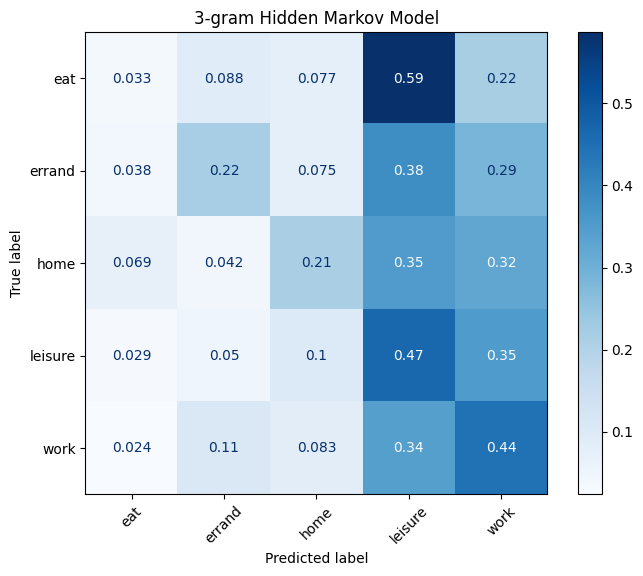

In [25]:
hmm_true_3 = [label for seq in true_purposes_3 for label in seq]
hmm_pred_3 = [label for seq in pred_purposes_3 for label in seq]

eval_baseline(
    y_true=hmm_true_3,
    y_pred=hmm_pred_3,
    label_names=PURPOSE_NAMES,
    title="3-gram Hidden Markov Model"
)


***Edge-emitting HMM Eval***

[[0.         0.08877795 0.51812459 0.28369872 0.10939874]
 [0.         0.23613703 0.39488021 0.20240316 0.1665796 ]
 [0.         0.03591591 0.60356679 0.20966104 0.15085627]
 [0.         0.05157701 0.46159845 0.28392099 0.20290355]
 [0.         0.10136646 0.28914737 0.2606437  0.34884246]]


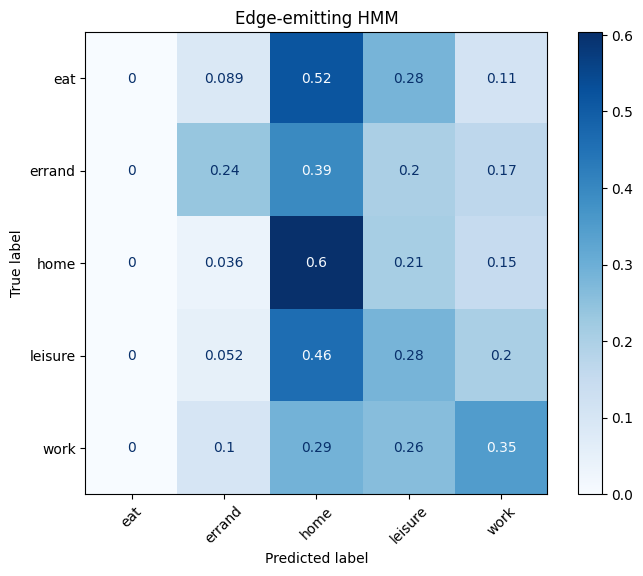

In [26]:
edge_true = [label for seq in true_purposes_edge for label in seq]
edge_pred = [label for seq in pred_purposes_edge for label in seq]

eval_baseline(
    y_true=edge_true,
    y_pred=edge_pred,
    label_names=PURPOSE_NAMES,
    title="Edge-emitting HMM"
)
